In [1]:
###   Imports and Logging   ###
import sys
import logging
import math
import copy
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib import __version__ as pltver
import matplotlib.ticker as ticker
from skaero.atmosphere import coesa
from skaero import __version__ as skver


logging.basicConfig(
    level=logging.INFO,
    format=' %(asctime)s -  %(levelname)s -  %(message)s'
)

logging.info('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
logging.info('Python version: {}'.format(sys.version))
logging.info('Author: Benjamin Crews')
logging.info('Numpy version: {}'.format(np.version.version))
logging.info('Pandas version: {}'.format(pd.__version__))
logging.info('Matplotlib version: {}'.format(pltver))
logging.info('SciKit-Aero version: {}'.format(skver))
logging.info('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

 2020-04-11 17:36:39,106 -  INFO -  =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
 2020-04-11 17:36:39,108 -  INFO -  Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
 2020-04-11 17:36:39,111 -  INFO -  Author: Benjamin Crews
 2020-04-11 17:36:39,114 -  INFO -  Numpy version: 1.16.2
 2020-04-11 17:36:39,120 -  INFO -  Pandas version: 0.24.2
 2020-04-11 17:36:39,126 -  INFO -  Matplotlib version: 3.0.3
 2020-04-11 17:36:39,128 -  INFO -  SciKit-Aero version: 0.1
 2020-04-11 17:36:39,129 -  INFO -  =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [6]:
#######################################
###   Input Rotor Characteristics   ###
#######################################
# Main Rotor
D = 35            # [ft]
R = D/2           
b = 4             # [number of blades, no units]
CHORD = 10.4      # [in]
OMEGA = 43.2      # [rad/s]
# Rotor Solidity
sol = b*CHORD/(12*math.pi*R)
# Rotor Area
A = math.pi*R**2
v_tip = OMEGA*R   # [ft/s]


#########################################
###   Input Vehicle Characteristics   ###
#########################################

# Vehicle Data
GW = 5000               # [lbs]
# Assume a 3% download
THRUST = 1.03*GW        # [lbs]

# Tail Data
# Tail length to TR center of thrust
l_tail = 21.21          # [ft]
# Vertical tail area
S_vt = 20.92            # [ft2]
# Vertical tail lift coef.
cl_vt = 0.22            # []
# Vertical tail aspect ratio
AR_vt = 3
# Tail Rotor diameter
D_tr = 5.42             # [ft]
R_tr = D_tr/2
b_tr = 4
CHORD_tr = 7            # [in]
v_tip_tr = 650          # [ft/s]
sol_tr = 0.2741         # []
cd0_tr = 0.015          # []

# Engine Data
eta_MRxsmn = 0.985      # []
eta_TRxsmn = 0.9712     # []
eta_xsmn_co = 0.986     # []
pwr_acc = 10            # [hp]
eta_inst = 0.95
xsmn_lim = 674          # [hp]
pwr_lim = 813           # [hp]



######################################
###       Ambient Conditions       ###
######################################
alt = 0                 # [m]
# an atmosphere object at 0 height
atm = coesa.table(alt)

# Convert the atmosphere units to imperial.
# prop_units =  [units.m, units.kelvin, units.pascal, units.kg/(units.m**3)]
h = atm[0]*3.28084     # [ft]
T = atm[1]*1.8         # [R]
p = atm[2]/6895        # [psi]
rho = atm[3]/515       # [slug/ft3]


# Spit out the converted input to the log (and make it readable)
logging.info('')
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('Main Rotor Inputs:')
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Diameter', val=D, unit='ft'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='(constant) Chord', val=CHORD, unit='in'))
logging.info('   {name:>17}: {val:>7.3f} [{unit}]'.format(name='Num Blades', val=b, unit=''))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Rotational Speed', val=OMEGA, unit='rad/s'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Tip Speed', val=v_tip, unit='ft/s'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Area', val=A, unit='ft2'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Solidity', val=sol, unit=''))
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('Tail Rotor Inputs:')
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Diameter', val=D_tr, unit='ft'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='(constant) Chord', val=CHORD_tr, unit='in'))
logging.info('   {name:>17}: {val:>7.3f} [{unit}]'.format(name='Num Blades', val=b_tr, unit=''))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Rotational Speed', val=v_tip_tr/R_tr, unit='rad/s'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Tip Speed', val=v_tip_tr, unit='ft/s'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Area', val=math.pi*D_tr**2/4, unit='ft2'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Solidity', val=sol_tr, unit=''))
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('Vehicle Characteristics:')
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Tail Length', val=l_tail, unit='ft'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='VFin Area', val=S_vt, unit='ft2'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='VFin Lift Coef.', val=cl_vt, unit=''))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='VFin Aspect Ratio', val=AR_vt, unit=''))
logging.info('')
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='MR Trans. Eff.', val=eta_MRxsmn, unit=''))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='TR Trans. Eff.', val=eta_TRxsmn, unit=''))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Cobox Eff.', val=eta_xsmn_co, unit=''))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Install. Loss', val=eta_inst, unit=''))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Trans. Limit', val=xsmn_lim, unit='hp'))
logging.info('   {name:>17}: {val:>7.3f} [{unit:}]'.format(name='Engine Limit', val=pwr_lim, unit='hp'))
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('Atmospheric Properties:')
logging.info('   {name:>17}: {val:>9.5f} [{unit:}]'.format(name='Altitude', val=h, unit='ft'))
logging.info('   {name:>17}: {val:>9.5f} [{unit:}]'.format(name='Temperature', val=T, unit='R'))
logging.info('   {name:>17}: {val:>9.5f} [{unit:}]'.format(name='Pressure', val=p, unit='psi'))
logging.info('   {name:>17}: {val:>9.5f} [{unit:}]'.format(name='Density', val=rho, unit='slug/ft3'))
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('')

 2020-04-11 17:58:36,279 -  INFO -  
 2020-04-11 17:58:36,280 -  INFO -  -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 2020-04-11 17:58:36,280 -  INFO -  Main Rotor Inputs:
 2020-04-11 17:58:36,281 -  INFO -              Diameter:  35.000 [ft]
 2020-04-11 17:58:36,282 -  INFO -      (constant) Chord:  10.400 [in]
 2020-04-11 17:58:36,282 -  INFO -            Num Blades:   4.000 []
 2020-04-11 17:58:36,283 -  INFO -      Rotational Speed:  43.200 [rad/s]
 2020-04-11 17:58:36,283 -  INFO -             Tip Speed: 756.000 [ft/s]
 2020-04-11 17:58:36,284 -  INFO -                  Area: 962.113 [ft2]
 2020-04-11 17:58:36,284 -  INFO -              Solidity:   0.063 []
 2020-04-11 17:58:36,285 -  INFO -  -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 2020-04-11 17:58:36,286 -  INFO -  Tail Rotor Inputs:
 2020-04-11 17:58:36,288 -  INFO -              Diameter:   5.420 [ft]
 2020-04-11 17:58:36,288 -  INFO -      (constant) Chord:   7.000 [in]
 2020-04-11 17:58:36,289 -  INFO -            Nu

In [9]:
####################################
###  Vehicle Hover Performance   ###
###           (HOGE)             ###
####################################
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('Beginning HOGE calculations...')

# TEMP: Inputs
delta_1 = -0.0216
delta_2 = 0.4
k_i = 1.1
CLIMB_RATE = 0   #[ft/min]
CLIMB_RATE = CLIMB_RATE/60  # Convert to [ft/s]
    

###   Airfoil Lift factor correction from 2d to 3d   ###

# TODO: a_0 = 2*pi ; a = a_0 / (1 + 57.3*a_0/(pi*AR))
# 2pi is the ideal, infinite airfoil with no edge effects.
# This equation transforms it into a 3d lift-curve-slope
# 57.3 means a is in cl/rad, but 2pi is cl/deg. So convert to rad first.

# TODO: AR = R/C
# Aspect ratio is Rotor radius over the equivalent chord.
ASPECT_RATIO = 12*R/CHORD

a_0 = 2*math.pi
a = a_0 / (1 + a_0/(math.pi*ASPECT_RATIO))



###   Compressibility correction factor   ###

#       1st term of 3-term profile drag is for compressible flow only.
#       need to correct this to account for compressibilty of such a fast
#       moving rotor.
#       delta_0, the 1st drag term, is: d_0i/(sqrt(abs(Mach#**2 - 1)))
#       d_0i, the uncorrected 1st term, is given.

# The Mach num here is the mach @ 80% blade station = v_tip*0.8/c_sound
# c_sound is the local speed of sound, aka sqrt(gamma*R*T) = sqrt(1.4*1716.4*T), where T is in Rankine.
c_sound = math.sqrt(1.4*1716.4*T)
mach_08 = v_tip*0.8/c_sound
delta_0 = 0.0080/math.sqrt(abs(mach_08**2 - 1))


# Get Ct from Momentum theory = T/(rho*A*v_tip**2)
Ct_mom = THRUST/(rho*A*v_tip**2)

# Get B correction for tip-loss = 1 - (sqrt(2*Ct)/b)
B = 1 - math.sqrt(2*Ct_mom)/b

#       Ideal to linear twist correction
#       Power*correction = linear-twist power, based on ideal momentum theory calculations.
#       HP_i*k_i = HP_lin , k_i is given, usually 5-10% more (k_i=1.1)
#       HP_i = Power (converted to horsepower)
#       Power = C_p*rho*A*v_tip**3
#       C_p = C_q = 3-term drag model


C_qi = 0.5*Ct_mom*math.sqrt( (CLIMB_RATE/(OMEGA*R))**2 + 2*Ct_mom/B**2 )
C_qvi = CLIMB_RATE*Ct_mom/(2*OMEGA*R)
C_q0 = sol*delta_0/8
C_q1 = (2*delta_1/(3*a))*(Ct_mom/B**2)
C_q2 = (4*delta_2/(sol*a**2))*(Ct_mom/B**2)**2

C_q = C_qi + C_qvi + C_q0 + C_q1 + C_q2

P = C_q*rho*A*v_tip**3   # [ft*lbs/s]
HP_i = P/550             # [hp]
HP_MR = HP_i * k_i       # [hp]

Q = HP_MR*550*R/v_tip    # [lb*ft]


## TR Calculations
T_tr = Q/(2*l_tail)      # [lbs]
Ct_trmom = T_tr/(rho*A*v_tip_tr**2)
B_tr = 1 - math.sqrt(2*Ct_trmom)/b_tr
vi_tr = math.sqrt(T_tr/(2*rho*math.pi*(B_tr*R_tr)**2))   # [ft/s]
# Induced horsepower
HPi_tr = T_tr*vi_tr/550  # [hp]
# Profile horsepower
HPpro_tr = sol_tr*cd0_tr*rho*math.pi*R_tr**2*v_tip_tr**3 / 4400   # [hp]
HP_TR = HPi_tr + HPpro_tr   # [hp]

SHP_ins = HP_MR + HP_TR + 10 +   \
          HP_MR*(1-(eta_MRxsmn*eta_xsmn_co)) + HP_TR*(1-eta_TRxsmn*eta_xsmn_co) + 10*(eta_xsmn_co)
SHP_unins = SHP_ins/eta_inst   # [hp]


logging.info('   {name:>18}: {val:>9.5f} [{unit:}]'.format(name='3D Lift Coef.', val=a, unit='cl/rad'))
logging.info('')
logging.info('Compressibility Correction: ')
logging.info('   {name:>18}: {val:>9.5f} [{unit:}]'.format(name='0.8STA Mach Num', val=mach_08, unit=''))
logging.info('   {name:>18}: {val:>9.5f} [{unit:}]'.format(name='delta_0', val=delta_0, unit=''))
logging.info('')
logging.info('Performance Metrics: ')
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='Coef. of Thrust', val=Ct_mom, unit=''))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='Tip-Loss Factor', val=B, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_qi', val=C_qi, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_qvi', val=C_qvi, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_q0', val=C_q0, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_q1', val=C_q1, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_q2', val=C_q2, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='Coef. of Pwr/Torq', val=C_q, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='Total, Ideal Power', val=P, unit='ft*lbs/s'))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='MR Power', val=HP_MR, unit='hp'))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='Total Torque', val=Q, unit='lb-ft'))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='TR Power', val=HP_TR, unit='hp'))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='Engine Power', val=SHP_ins, unit='hp'))
logging.info('')
logging.info('   {name:>30}: {val:>10.3f} [{unit:}]'.format(name='Uninstalled Engine Power', val=SHP_unins, unit='hp'))
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('')

 2020-04-11 18:17:55,934 -  INFO -  -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 2020-04-11 18:17:55,935 -  INFO -  Beginning HOGE calculations...
 2020-04-11 18:17:55,936 -  INFO -          3D Lift Coef.:   5.71694 [cl/rad]
 2020-04-11 18:17:55,937 -  INFO -  
 2020-04-11 18:17:55,937 -  INFO -  Compressibility Correction: 
 2020-04-11 18:17:55,938 -  INFO -        0.8STA Mach Num:   0.54174 []
 2020-04-11 18:17:55,938 -  INFO -                delta_0:   0.00952 []
 2020-04-11 18:17:55,939 -  INFO -  
 2020-04-11 18:17:55,939 -  INFO -  Performance Metrics: 
 2020-04-11 18:17:55,940 -  INFO -        Coef. of Thrust:  3.937E-03 []
 2020-04-11 18:17:55,940 -  INFO -        Tip-Loss Factor:      0.978 []
 2020-04-11 18:17:55,942 -  INFO -                   C_qi:  1.787E-04 []
 2020-04-11 18:17:55,943 -  INFO -                  C_qvi:  0.000E+00 []
 2020-04-11 18:17:55,943 -  INFO -                   C_q0:  7.502E-05 []
 2020-04-11 18:17:55,944 -  INFO -                   C_q1: -1.037E-

In [10]:
####################################
###  Vehicle Hover Performance   ###
###           (HIGE)             ###
####################################
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('Beginning HIGE calculations...')

# HIGE is nearly equivalent to HOGE, except the THRUST is factored.
factor_HIGE = 1/1.2
THRUST = THRUST*factor_HIGE

## Everything below here is the same as HOGE calcs.
# TODO: Make a function call instead of copy/paste code.
# Get Ct from Momentum theory = T/(rho*A*v_tip**2)
Ct_mom = THRUST/(rho*A*v_tip**2)

# Get B correction for tip-loss = 1 - (sqrt(2*Ct)/b)
B = 1 - math.sqrt(2*Ct_mom)/b

#       Ideal to linear twist correction
#       Power*correction = linear-twist power, based on ideal momentum theory calculations.
#       HP_i*k_i = HP_lin , k_i is given, usually 5-10% more (k_i=1.1)
#       HP_i = Power (converted to horsepower)
#       Power = C_p*rho*A*v_tip**3
#       C_p = C_q = 3-term drag model


C_qi = 0.5*Ct_mom*math.sqrt( (CLIMB_RATE/(OMEGA*R))**2 + 2*Ct_mom/B**2 )
C_qvi = CLIMB_RATE*Ct_mom/(2*OMEGA*R)
C_q0 = sol*delta_0/8
C_q1 = (2*delta_1/(3*a))*(Ct_mom/B**2)
C_q2 = (4*delta_2/(sol*a**2))*(Ct_mom/B**2)**2

C_q = C_qi + C_qvi + C_q0 + C_q1 + C_q2

P = C_q*rho*A*v_tip**3   # [ft*lbs/s]
HP_i = P/550             # [hp]
HP_MR = HP_i * k_i       # [hp]

Q = HP_MR*550*R/v_tip    # [lb*ft]


## TR Calculations
T_tr = Q/(2*l_tail)      # [lbs]
Ct_trmom = T_tr/(rho*A*v_tip_tr**2)
B_tr = 1 - math.sqrt(2*Ct_trmom)/b_tr
vi_tr = math.sqrt(T_tr/(2*rho*math.pi*(B_tr*R_tr)**2))   # [ft/s]
# Induced horsepower
HPi_tr = T_tr*vi_tr/550  # [hp]
# Profile horsepower
HPpro_tr = sol_tr*cd0_tr*rho*math.pi*R_tr**2*v_tip_tr**3 / 4400   # [hp]
HP_TR = HPi_tr + HPpro_tr   # [hp]

SHP_ins = HP_MR + HP_TR + 10 +   \
          HP_MR*(1-(eta_MRxsmn*eta_xsmn_co)) + HP_TR*(1-eta_TRxsmn*eta_xsmn_co) + 10*(eta_xsmn_co)
SHP_unins = SHP_ins/eta_inst   # [hp]


logging.info('   {name:>18}: {val:>9.5f} [{unit:}]'.format(name='3D Lift Coef.', val=a, unit='cl/rad'))
logging.info('')
logging.info('Compressibility Correction: ')
logging.info('   {name:>18}: {val:>9.5f} [{unit:}]'.format(name='0.8STA Mach Num', val=mach_08, unit=''))
logging.info('   {name:>18}: {val:>9.5f} [{unit:}]'.format(name='delta_0', val=delta_0, unit=''))
logging.info('')
logging.info('Performance Metrics: ')
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='Coef. of Thrust', val=Ct_mom, unit=''))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='Tip-Loss Factor', val=B, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_qi', val=C_qi, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_qvi', val=C_qvi, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_q0', val=C_q0, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_q1', val=C_q1, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='C_q2', val=C_q2, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='Coef. of Pwr/Torq', val=C_q, unit=''))
logging.info('   {name:>18}: {val:>10.3E} [{unit:}]'.format(name='Total, Ideal Power', val=P, unit='ft*lbs/s'))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='MR Power', val=HP_MR, unit='hp'))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='Total Torque', val=Q, unit='lb-ft'))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='TR Power', val=HP_TR, unit='hp'))
logging.info('   {name:>18}: {val:>10.3f} [{unit:}]'.format(name='Engine Power', val=SHP_ins, unit='hp'))
logging.info('')
logging.info('   {name:>30}: {val:>10.3f} [{unit:}]'.format(name='Uninstalled Engine Power', val=SHP_unins, unit='hp'))
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('')

 2020-04-11 18:19:27,953 -  INFO -  -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 2020-04-11 18:19:27,954 -  INFO -  Beginning HIGE calculations...
 2020-04-11 18:19:27,956 -  INFO -          3D Lift Coef.:   5.71694 [cl/rad]
 2020-04-11 18:19:27,957 -  INFO -  
 2020-04-11 18:19:27,958 -  INFO -  Compressibility Correction: 
 2020-04-11 18:19:27,958 -  INFO -        0.8STA Mach Num:   0.54174 []
 2020-04-11 18:19:27,959 -  INFO -                delta_0:   0.00952 []
 2020-04-11 18:19:27,960 -  INFO -  
 2020-04-11 18:19:27,961 -  INFO -  Performance Metrics: 
 2020-04-11 18:19:27,961 -  INFO -        Coef. of Thrust:  3.281E-03 []
 2020-04-11 18:19:27,962 -  INFO -        Tip-Loss Factor:      0.980 []
 2020-04-11 18:19:27,963 -  INFO -                   C_qi:  1.356E-04 []
 2020-04-11 18:19:27,964 -  INFO -                  C_qvi:  0.000E+00 []
 2020-04-11 18:19:27,964 -  INFO -                   C_q0:  7.502E-05 []
 2020-04-11 18:19:27,965 -  INFO -                   C_q1: -8.610E-

In [11]:
## Note: With all the correction factors above, we have a roughly approximate solution
#        for realistic power, using just momentum theory. The blade-element portion
#        is not necessary yet.

#########################################
###   Blade-Element Momentum Theory   ###
###     Downwash Distribution         ###
###            (HOGE)                 ###
#########################################
def thrust_generator(num: int,
                    TWIST: int,
                    theta_tip: float,
                    sol: float,
                    LIFT_CURVE_SLOPE: float,
                    v_tip: float,
                    CLIMB_RATE: float,
                    R: float,
                    B: float = 1.0
                   ) -> pd.DataFrame:
    '''
    Note: Despite the name, this function is not a pythonic generator.
    
    This function generates a thrust table for a rotor,
    using Blade-Element-Momentum Theory.
    
    This model assumes a constant-chord blade with no root cut-out,
    and a linear twist.
    '''
    df = pd.DataFrame(np.linspace(0.001, B, num), columns=['x'])
    df['theta'] = TWIST*(df.x - 1) + theta_tip

    c_1 = sol*LIFT_CURVE_SLOPE*v_tip/16
    c_2 = CLIMB_RATE/2 + sol*LIFT_CURVE_SLOPE*v_tip/16
    c_3 = 4*CLIMB_RATE**2/(sol*LIFT_CURVE_SLOPE*v_tip)

    # create a temporary variable which is a function of
    # blade station and blade-element angle
    # used to calculate the final induced velocity.
    df['v_step'] = 2*(np.radians(df.theta)*df.x*v_tip - CLIMB_RATE)
    df['v_induced'] = c_2 * (-1 + np.sqrt(1 + df.v_step/(c_3 + CLIMB_RATE + c_1)))
    # Calculate the differential thrust of each blade element
    # Until I know a way to elegantly do this with pandas
    # convert everything to np arrays and loop through
    # TODO: cleanup code
    x_temp = np.array(df.x)
    x_temp = np.append(x_temp, 0)
    vi_temp = np.array(df.v_induced)
    vi_temp[-1] = 0
    df['v_induced'] = -vi_temp
    dT_temp = np.array([])
    for i, vi in enumerate(vi_temp):
        dT_temp = np.append(dT_temp, 2*math.pi*rho*(CLIMB_RATE+vi)*vi*x_temp[i]*R*R*(x_temp[i+1] - x_temp[i]) )


    df['dT'] = dT_temp
    
    return df


def T_err(theta, req, args):
    '''
    Calculates the thrust error for iteration.
    '''
    df = thrust_generator(num = args[0],
                          TWIST = args[1],
                          theta_tip = theta,
                          sol = args[2],
                          LIFT_CURVE_SLOPE= args[3],
                          v_tip = args[4],
                          CLIMB_RATE = args[5],
                          R = args[6],
                          B = args[7]
                         )
    
    calcd = df.dT.sum()
    err = abs(req-calcd)/req
    return err


args = (50, -12, sol, a, v_tip, CLIMB_RATE, R, 1)
res = scipy.optimize.minimize(T_err, x0=2, args=(THRUST, args), tol=0.01, options={'disp':True})
logging.info('  SciPy Optimization resulted in theta_tip = {:.3f}, after {} iterations.'.format(res.x[0], res.nfev))
logging.info('  Using optimization results to calculate Main Rotor data...')
logging.info('')
theta = res.x[0]
MR = thrust_generator(num = args[0],
                          TWIST = args[1],
                          theta_tip = theta,
                          sol = args[2],
                          LIFT_CURVE_SLOPE= args[3],
                          v_tip = args[4],
                          CLIMB_RATE = args[5],
                          R = args[6],
                          B = args[7]
                         )

logging.info(f'   Total Main Rotor Thrust = {MR.dT.sum():10.2f} [lb]')
logging.info('')
logging.info('Blade Station Downwash Table: ')
print(MR)

 2020-04-11 18:20:12,900 -  INFO -    SciPy Optimization resulted in theta_tip = 8.327, after 108 iterations.
 2020-04-11 18:20:12,901 -  INFO -    Using optimization results to calculate Main Rotor data...
 2020-04-11 18:20:12,901 -  INFO -  
 2020-04-11 18:20:12,909 -  INFO -     Total Main Rotor Thrust =    4291.67 [lb]
 2020-04-11 18:20:12,909 -  INFO -  
 2020-04-11 18:20:12,910 -  INFO -  Blade Station Downwash Table: 


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 108
         Gradient evaluations: 36
           x      theta      v_step  v_induced          dT
0   0.001000  20.315354    0.536110  -0.265978    0.000007
1   0.021388  20.070701   11.328095  -4.945954    0.048822
2   0.041776  19.826048   21.856825  -8.704328    0.295356
3   0.062163  19.581395   32.122297 -11.902473    0.821792
4   0.082551  19.336742   42.124514 -14.710173    1.666909
5   0.102939  19.092089   51.863473 -17.223567    2.849569
6   0.123327  18.847436   61.339176 -19.503443    4.377569
7   0.143714  18.602782   70.551623 -21.591176    6.251820
8   0.164102  18.358129   79.500813 -23.516453    8.468599
9   0.184490  18.113476   88.186746 -25.301445   11.020897
10  0.204878  17.868823   96.609423 -26.963231   13.899276
11  0.225265  17.624170  104.768843 -28.515297   17.092440
12  0.245653  17.379517  112.665007 -29.968515   20.587640
13

In [13]:
#######################################
###   Forward Flight Calculations   ###
#######################################
logging.info('Beginning Forward Flight Calculations...')


    #    Main Rotor Calculations
    ##################################

# Max Airspeed, in knots
VNE = 160
# Equivalent Flat-Plate Drag Area
fe = 12.4   # [ft2]


df = pd.DataFrame(data=[20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160], columns=['Airspeed'])

# Dynamic Pressure = 1/2 rho V^2
df['q'] = 0.5*rho*(df.Airspeed * 1.68781)**2    # 1.689 is simply the conversion factor from kts to ft/s

# Advance Ratio
df['mu'] = df.Airspeed * 1.689 / v_tip

# Hover Induced Velocity
v_0 = math.sqrt(THRUST/(2*rho*math.pi*(B*R)**2))
# Induced velocity in Forward Flight, using Glauert's Model
df['v_if'] = v_0 * (-0.5*(df.Airspeed/v_0)**2 + np.sqrt((df.Airspeed/v_0)**4 / 4 + 1))

# Thrust coef. over solidity
df['Cts'] = THRUST/(rho*A*v_tip**2) / sol

# Blade loading
df['tc'] = 2*df.Cts

# Empirical lower bound of blade loading
df['tc_lower'] = -0.6885*df.Cts + 0.3555

# Change in Drag Coef. (due to retreating blade stall)
# From a NASA CR
df['F'] = ((df.Cts/(1-df.mu)**2) * (1 + fe*df.q/GW)) - 0.1376
df['del_cds'] = 18.3*(1-df.mu)**2*df.F**3
# This value should never be less than zero, so clip it.
df.del_cds.clip(lower=0, inplace=True)

# Mach Drag Divergence of the airfoil: At what Mach would shockwaves start to form?
df['MDD'] = 0.82 - 2.4*df.Cts

# MY90. Mach at the tip
df['MY90'] = (df.Airspeed*1.68781 + v_tip)/c_sound

# Change in Drag Coef. from compressibility
df['del_cdcomp'] = 0.2*(df.MY90 - df.MDD)**3 + 0.0085*(df.MY90 - df.MDD)

# Total Drag Coef.
df['cd'] = 0.0095 + df.del_cds + df.del_cdcomp

# Induced Horsepower
df['Hp_ind'] = THRUST*df.v_if/550

# Profile Horsepower
df['Hp_pro'] = sol*df.cd*(1+4.65*df.mu**2)*rho*math.pi*R**2*v_tip**3/4400

# Parasite Power
df['Hp_par'] = fe*rho*(df.Airspeed*1.68781)**3/1100

# Main Rotor Horsepower
df['MR_hp'] = df.Hp_ind + df.Hp_pro + df.Hp_par

# Main Rotor Torque
df['MR_Q'] = 5252*df.MR_hp/(OMEGA*60/(2*math.pi))

# Anti-torque Required from Tail Rotor Thrust
# MR Torque over the moment arm
df['T_at'] = df.MR_Q/(2*l_tail)

MR = df.copy()
MR

 2020-04-11 18:22:38,018 -  INFO -  Beginning Forward Flight Calculations...


,Airspeed,q,mu,v_if,Cts,tc,tc_lower,F,del_cds,MDD,MY90,del_cdcomp,cd,Hp_ind,Hp_pro,Hp_par,MR_hp,MR_Q,T_at
0,20,1.355207,0.044683,25.503264,0.052036,0.104072,0.319673,-0.080391,0.000000e+00,0.695114,0.707415,0.000105,0.009605,199.002743,137.372268,1.031379,337.406390,4295.590683,101.263335
1,30,3.049216,0.067024,20.012944,0.052036,0.104072,0.319673,-0.077367,0.000000e+00,0.695114,0.722533,0.000237,0.009737,156.161605,140.865106,3.480904,300.507615,3825.824730,90.189173
2,40,5.420828,0.089365,14.801414,0.052036,0.104072,0.319673,-0.074006,0.000000e+00,0.695114,0.737652,0.000377,0.009877,115.495879,145.161179,8.251031,268.908089,3423.524619,80.705437
3,50,8.470044,0.111706,10.763448,0.052036,0.104072,0.319673,-0.070268,0.000000e+00,0.695114,0.752770,0.000528,0.010028,83.987508,150.355435,16.115294,250.458238,3188.635738,75.168216
4,60,12.196864,0.134048,7.933919,0.052036,0.104072,0.319673,-0.066108,0.000000e+00,0.695114,0.767888,0.000696,0.010196,61.908607,156.551791,27.847229,246.307627,3135.793451,73.922524
5,70,16.601287,0.156389,6.000817,0.052036,0.104072,0.319673,-0.061473,0.000000e+00,0.695114,0.783007,0.000883,0.010383,46.824560,163.865861,44.220367,254.910789,3245.322086,76.504528
6,80,21.683314,0.178730,4.663999,0.052036,0.104072,0.319673,-0.056302,0.000000e+00,0.695114,0.798125,0.001094,0.010594,36.393324,172.427682,66.008245,274.829251,3498.908163,82.482512
7,90,27.442944,0.201071,3.715794,0.052036,0.104072,0.319673,-0.050527,0.000000e+00,0.695114,0.813243,0.001334,0.010834,28.994451,182.384445,93.984396,305.363292,3887.643365,91.646473
8,100,33.880177,0.223413,3.024358,0.052036,0.104072,0.319673,-0.044068,0.000000e+00,0.695114,0.828362,0.001606,0.011106,23.599161,193.903218,128.922354,346.424733,4410.405078,103.969945
9,120,48.787456,0.268095,2.110434,0.052036,0.104072,0.319673,-0.028708,0.000000e+00,0.695114,0.858599,0.002264,0.011764,16.467783,222.410835,222.777828,461.656446,5877.443901,138.553604


In [14]:

    #    Tail Rotor Calculations
    #################################

# Copy the dataframe to a new variable, for Tail calculations
# Carry over the airspeed and anti-torque thrust
TR = pd.DataFrame(data=MR.Airspeed)
TR['T_at'] = MR.T_at.copy()
TR['q'] = MR.q.copy()

# Calculate the anti-torque provided
# by the vertical tail
# Lift = cl*wing_area*dynamic_pressure
TR['L_vt'] = cl_vt*S_vt*TR.q

# Anti-torque minus Vfin Lift
TR['TTR'] = TR.T_at - TR.L_vt

# Induced Drag from the Vfin
TR['D_vt'] = TR.L_vt**2/(2*TR.q*S_vt*AR_vt)

# Calculate the "hover induced velocity" of TR
TR['v0_tr'] = np.sqrt(abs(TR.TTR)/(2*rho*math.pi*R_tr**2))

# Calculate the forward flight induced velocity
TR['v_if_tr'] = TR.v0_tr * (-0.5*(TR.Airspeed/TR.v0_tr)**2 + np.sqrt((df.Airspeed/TR.v0_tr)**4 / 4 + 1))

# Induced Horsepower
TR['HP_i_tr'] = TR.TTR*TR.v_if_tr/550

# Profile Horsepower
TR['HP_pro_tr'] = sol_tr*cd0_tr*(1+4.65*MR.mu**2)*rho*math.pi*R_tr**2*v_tip_tr**3 / 4400

# Total TR Horsepower
TR['HP_tr'] = TR.HP_i_tr + TR.HP_pro_tr

TR

,Airspeed,T_at,q,L_vt,TTR,D_vt,v0_tr,v_if_tr,HP_i_tr,HP_pro_tr,HP_tr
0,20,101.263335,1.355207,6.237205,95.026130,0.228698,29.423750,23.401435,4.043178e+00,14.214056,18.257234
1,30,90.189173,3.049216,14.033712,76.155462,0.514569,26.340682,14.311847,1.981682e+00,14.377491,16.359173
2,40,80.705437,5.420828,24.948821,55.756616,0.914790,22.538484,6.551169,6.641291e-01,14.606299,15.270428
3,50,75.168216,8.470044,38.982532,36.185684,1.429360,18.157033,2.354138,1.548838e-01,14.900481,15.055364
4,60,73.922524,12.196864,56.134846,17.787677,2.058278,12.730226,0.571911,1.849630e-02,15.260036,15.278533
5,70,76.504528,16.601287,76.405763,0.098765,2.801545,0.948590,0.000174,3.128098e-08,15.684966,15.684966
6,80,82.482512,21.683314,99.795282,-17.312770,3.659160,12.559136,0.309340,-9.737325e-03,16.175269,16.165531
7,90,91.646473,27.442944,126.303404,-34.656932,4.631125,17.769350,0.691626,-4.358114e-02,16.730945,16.687364
8,100,103.969945,33.880177,155.930129,-51.960183,5.717438,21.757642,1.027698,-9.708977e-02,17.351996,17.254906
9,120,138.553604,48.787456,224.539385,-85.985781,8.233111,27.989157,1.518194,-2.373511e-01,18.790218,18.552867


In [15]:

    #   Power Calculations
    #############################

Power = pd.DataFrame(data=MR.Airspeed)
Power['MR_hp'] = MR.MR_hp.copy()
Power['TR_hp'] = TR.HP_tr.copy()

Power['del_MRxsmn'] = Power.MR_hp*(1-(eta_MRxsmn*eta_xsmn_co))
Power['del_TRxsmn'] = Power.TR_hp*(1-eta_TRxsmn)
Power['del_Acc_co'] = pwr_acc*(1-eta_xsmn_co)

Power['SHP_inst_req'] = Power.MR_hp + Power.TR_hp + Power.del_MRxsmn \
                      + Power.del_TRxsmn + pwr_acc + Power.del_Acc_co

Power['del_inst'] = Power.SHP_inst_req*(1-eta_inst)
Power['SHP_uninst'] = Power.SHP_inst_req + Power.del_inst

Power['L_D'] = GW*Power.Airspeed*1.689 / (550*Power.SHP_uninst)

Power['Pwr_ratio'] = Power.SHP_uninst/pwr_lim

# TODO: Calculate fuel consumption based on power
#       I have no idea how to do this...
# Power['sfc'] = 

Power

,Airspeed,MR_hp,TR_hp,del_MRxsmn,del_TRxsmn,del_Acc_co,SHP_inst_req,del_inst,SHP_uninst,L_D,Pwr_ratio
0,20,337.406390,18.257234,9.713930,0.525808,0.14,376.043362,18.802168,394.845531,0.777749,0.485665
1,30,300.507615,16.359173,8.651614,0.471144,0.14,336.129546,16.806477,352.936024,1.305155,0.434116
2,40,268.908089,15.270428,7.741864,0.439788,0.14,302.500169,15.125008,317.625178,1.933669,0.390683
3,50,250.458238,15.055364,7.210693,0.433594,0.14,283.297890,14.164894,297.462784,2.580919,0.365883
4,60,246.307627,15.278533,7.091197,0.440022,0.14,279.257378,13.962869,293.220247,3.141914,0.360665
5,70,254.910789,15.684966,7.338882,0.451727,0.14,288.526363,14.426318,302.952681,3.547809,0.372636
6,80,274.829251,16.165531,7.912334,0.465567,0.14,309.512684,15.475634,324.988318,3.779716,0.399740
7,90,305.363292,16.687364,8.791409,0.480596,0.14,341.462662,17.073133,358.535795,3.854313,0.441003
8,100,346.424733,17.254906,9.973568,0.496941,0.14,384.290149,19.214507,403.504656,3.805296,0.496316
9,120,461.656446,18.552867,13.291089,0.534323,0.14,504.174725,25.208736,529.383461,3.480550,0.651148


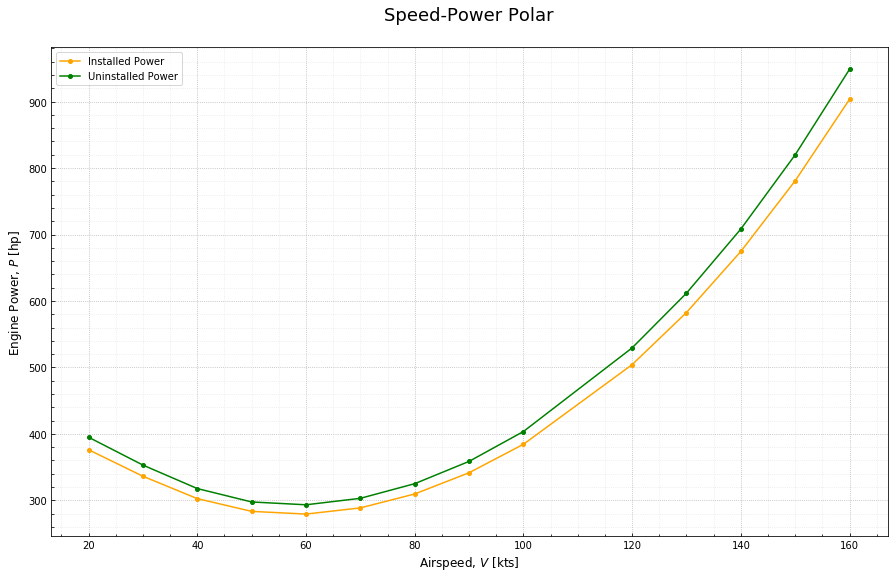

In [17]:
## This cell just plots the Speed-Power curve

fig, ax = plt.subplots(figsize=(15,9))

# Add the data and color it
ax.plot(Power.Airspeed, Power.SHP_inst_req, color='orange', label='Installed Power', marker='o', markersize='4')
ax.plot(Power.Airspeed, Power.SHP_uninst, color='green', label='Uninstalled Power', marker='o', markersize='4')
ax.legend()

# Axis labels
ax.set_xlabel('Airspeed, $V$ [kts]', fontsize=12)
ax.set_ylabel('Engine Power, $P$ [hp]', fontsize=12)
ax.set_title('Speed-Power Polar\n', fontsize=18)

# Move the axis and its label to the top
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()

# Set the ticks
# ax.xaxis.set_major_locator(ticker.FixedLocator([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
ax.tick_params(which='minor', width=0.75, length=2.5)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='both', direction='in')

# Set the grid lines
ax.grid(b=True, which='major', linestyle=':')
ax.grid(b=True, which='minor', linestyle=':', alpha=0.3)